In [156]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as la

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import noise
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2, FakeAthensV2, FakeAthens

# Homemade imports
from qiskit_algorithms import VarQITE, TimeEvolutionProblem, VarQRTE
from qiskit_algorithms.gradients import LinCombEstimatorGradient, LinCombQGT
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple, RealMcLachlanPrinciple
#import qiskit_algorithms.time_evolvers.variational.variational_principles.imaginary_mc_lachlan_principle as mc_lachlan
import qiskit.primitives.utils as utils

from qiskit.primitives import Estimator
from qiskit.primitives import BackendEstimator
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector

from qiskit_algorithms import SciPyRealEvolver


In [2]:
# Hamiltonian reading, TC
data = np.loadtxt('qubit_hamil_h2.txt', dtype=str) # H2, 0.7A sto6g
paulistrings = data[:,0] 
coefficients = (data[:,1])
#coefficients = [np.real(complex(coeff)) for coeff in coefficients]
coefficiencts = [complex(coeff) for coeff in coefficients]
paulis = list(zip(paulistrings, coefficients))
qubit_op = SparsePauliOp.from_list(paulis)
qubit_op = qubit_op.adjoint()
print(qubit_op)

# No TC Hamiltonian
driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.7",
    unit=DistanceUnit.ANGSTROM,
    charge=0,
    spin=0,
    basis='sto6g'
)
problem = driver.run()
h = problem.hamiltonian.second_q_op()

# Mapper
mapper = ParityMapper(num_particles = problem.num_particles)
qubit_op2 = mapper.map(h)
print(qubit_op2)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XY', 'YX', 'XX'],
              coeffs=[-1.09284335-0.j        ,  0.42027207-0.j        , -0.42027207-0.j        ,
 -0.01086588-0.j        ,  0.        -0.06359682j,  0.        +0.06359682j,
  0.1576953 -0.j        ])
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05178903+0.j,  0.4209349 +0.j, -0.4209349 +0.j, -0.01159108+0.j,
  0.17928567+0.j])


In [3]:
# Settings for all estimators
numshots = 1000000000
seed = 170

# Simple noise model with depolarizing error
prob_1 = 0.0001 # 1-qubit gate
prob_2 = 0.0001   # 2-qubit gate
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Estimators
estimator = Estimator(options={'seed': seed})
shot_estimator = Estimator(options={'seed': seed, 'shots': numshots})
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "noise_model": noise_model, # Disabling noise_model but having shotnoise means it runs only ONCE. VERY WEIRD! Is this our problem though?
    },
    run_options={"seed": seed, "shots": numshots},       
    transpile_options={"seed_transpiler": seed},       
    approximation=True                                 
)

#noisy_estimator = BackendEstimator(options={'seed': seed, 'shots': numshots}, backend=FakeAthens())


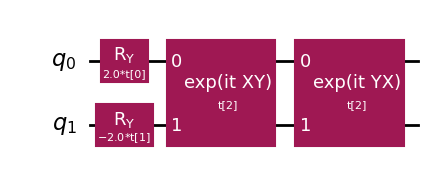

In [4]:
# Ansatz

# UCCSD
ansatz = UCCSD(num_spatial_orbitals = problem.num_spatial_orbitals, num_particles = problem.num_particles, qubit_mapper=mapper) # No initial state! By luck it still works in this case but.
init_param_values = [0,3*np.pi/2,-np.pi/2] # surely there should be some systematic way of doing this...
ansatz.decompose().decompose().draw("mpl")

# EfficientSU2
#ansatz = EfficientSU2(num_qubits = qubit_op2.num_qubits, reps=1, su2_gates=["ry"], skip_final_rotation_layer=True)
#init_param_values = [np.pi,np.pi]
#ansatz.decompose().draw("mpl")


In [5]:
# Testing the initial state
print(ansatz.num_parameters)
state = Statevector.from_int(0, 2**qubit_op.num_qubits)
test_circ = ansatz.assign_parameters(init_param_values)
state = state.evolve(test_circ)
state.draw('latex')

3


<IPython.core.display.Latex object>

In [6]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), 
                                                       gradient=LinCombEstimatorGradient(estimator), 
                                                       is_non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result = qite.evolve(time_evo)

In [7]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code, with shot noise.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(shot_estimator), 
                                                       gradient=LinCombEstimatorGradient(shot_estimator), 
                                                       is_non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=shot_estimator, 
               num_timesteps=num_timesteps)
result_shotnoise = qite.evolve(time_evo)

In [8]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code, with noise model.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(noisy_estimator), 
                                                       gradient=LinCombEstimatorGradient(noisy_estimator), 
                                                       is_non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=noisy_estimator, 
               num_timesteps=num_timesteps)
result_noise = qite.evolve(time_evo)

In [9]:
###############
### VarQITE ###
###############
# This is the non-TC Hamiltonian.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), gradient=LinCombEstimatorGradient(estimator))
time_evo = TimeEvolutionProblem(qubit_op2, 
                                time=total_time, 
                                aux_operators=[qubit_op2])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result2 = qite.evolve(time_evo)

In [10]:
data = np.loadtxt("energy_trace_h2.dat")
avqite_times = data[:,0]
avqite_energies = data[:,2]
initial_time=data[0,0]
initial_energy=data[0,2]
#print(f"Initial time: {initial_time}, Initial energy: {initial_energy}")

E0_noisy: -1.9218617751480747, E0_noTC: -1.88206774703718, E0_TC: -1.922521604267379


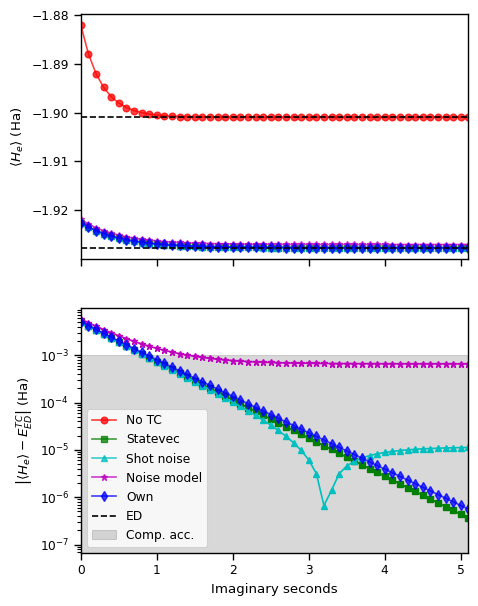

In [11]:
sns.set_context("paper")
fig, axs = plt.subplots(2,1,sharex=True)
fig.set_figheight(7)
fig.set_figwidth(5)
ax = axs[0]
ax2 = axs[1]
#DELTA_BIG = 50
DELTA_BIG = 2
sys = "h2"
e_exact = {"h2": -1.9276748321, "h4": -4.3860854160}
e_exact_notc = {"h2": -1.9009465237, "h4": None} 

h_exp_val = np.array([ele[0][0].real for ele in result.observables])
times = result.times
h_exp_val2 = np.array([ele[0][0].real for ele in result2.observables])
times2 = result2.times
h_exp_val_shotnoise = np.array([ele[0][0].real for ele in result_shotnoise.observables])
times_shotnoise = result_shotnoise.times
h_exp_val_noise = np.array([ele[0][0].real for ele in result_noise.observables])
times_noise = result_noise.times

print(f"E0_noisy: {h_exp_val_noise[0]}, E0_noTC: {h_exp_val2[0]}, E0_TC: {h_exp_val[0]}")

ax.plot(times2, h_exp_val2, '-ro', label= "No TC", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times, h_exp_val, '-gs', label= "Statevec", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times_shotnoise, h_exp_val_shotnoise, '-c^', label= "Shot noise", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times_noise, h_exp_val_noise, '-m*', label= "Noise model", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(avqite_times[::DELTA_BIG], avqite_energies[::DELTA_BIG], '-bd', label= "Own", alpha=0.75)
ax.plot([e_exact[sys]]*(int(times[-1])+15), '--k', label= "ED")
ax.plot([e_exact_notc[sys]]*(int(times[-1])+15), '--k')
ax.set_ylabel(r"$\langle H_e \rangle$ (Ha)")
#ax.legend()
ax.set_xlim([0, times[-1]])

#print(f"Final Qiskit electronic energy: {h_exp_val[-1]} Ha")
#print(f"Compare with Qutip ED: -4.3860854160 Ha")
#print(f"Compare with TC-VarQITE for UCCSD: -4.3860791082 Ha")


ax2.plot(times, abs(h_exp_val-e_exact[sys]), "-gs", label= "Statevec")
ax2.plot(times_shotnoise, abs(h_exp_val_shotnoise-e_exact[sys]), "-c^", label= "Shot noise")
ax2.plot(times_noise, abs(h_exp_val_noise-e_exact[sys]), "-m*", label= "Noise model")
ax2.plot(avqite_times[::DELTA_BIG], abs(avqite_energies-e_exact[sys])[::DELTA_BIG], "-bd", label= "Own", alpha=0.75)
ax2.fill_between([0,times[-1]],[1e-3,1e-3],color="grey",alpha=0.3,label="Comp. acc.")
ax2.set_xlabel("Imaginary seconds")
ax2.set_ylabel(r"$\left|\langle H_e \rangle - E_{ED}^{TC}\right|$ (Ha)")
ax2.set_yscale("log")
ax2.set_xlim([0, times[-1]])

h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
for index, label in enumerate(l2):
    if label not in l:
        l.append(label)
        h.append(h2[index])
ax2.legend(h, l)


In [12]:
# Moving on to QRTE, test system

hamiltonian_test = SparsePauliOp(["ZZ", "IX", "XI"], coeffs=[-0.2, -1, -1])
magnetisation_test = SparsePauliOp(["IZ", "ZI"], coeffs=[1, 1])
ansatz_test = EfficientSU2(hamiltonian_test.num_qubits, reps=1)
init_param_values_test = [np.pi/2 for _ in range(ansatz_test.num_parameters)]
var_principle = RealMcLachlanPrinciple(qgt=LinCombQGT(estimator), gradient=LinCombEstimatorGradient(estimator))
total_time = 10.0
num_timesteps = 400
evolution_problem_test = TimeEvolutionProblem(hamiltonian_test, total_time, aux_operators=[magnetisation_test])
var_qrte_test = VarQRTE(ansatz_test, init_param_values_test, var_principle, Estimator(), num_timesteps=num_timesteps)
evolution_result_re = var_qrte_test.evolve(evolution_problem_test)

init_circ_test = ansatz_test.assign_parameters(init_param_values_test)
evolution_problem_test2 = TimeEvolutionProblem(
    hamiltonian_test, total_time, initial_state=init_circ_test, aux_operators=[magnetisation_test]
)
rtev_test = SciPyRealEvolver(num_timesteps)
solution_test = rtev_test.evolve(evolution_problem_test2)

init_circ2 = ansatz_test.assign_parameters(init_param_values_test)
state = Statevector.from_int(0, 2**hamiltonian_test.num_qubits)
state = state.evolve(init_circ2)
state.draw('latex')

/Users/erikamagnusson/Library/CloudStorage/OneDrive-Chalmers/Documents/qiskit-algorithms/qiskit_algorithms/time_evolvers/variational/variational_principles/real_mc_lachlan_principle.py:197: UserWarning: A gradient instance with a setting for calculating real part of thegradient was provided. This variational principle requires theimaginary part. The setting to imaginary was changed automatically.
  warnings.warn(


I want you to know that Hermiticity is False according to my beliefs
[ 1.00000000e-01 -5.00000000e-01  5.00000000e-01  1.94289029e-17
  5.00000000e-01  5.00000000e-01 -5.27355937e-17 -5.00000000e-01]
[ 9.98611635e-02 -5.00043729e-01  4.99722286e-01  8.33012960e-05
  5.00624687e-01  5.00138837e-01 -2.49761543e-02 -4.99366871e-01]
[ 9.94458907e-02 -5.00171537e-01  4.97642337e-01  3.32003483e-04
  5.02490536e-01  4.99309333e-01 -4.98496249e-02 -4.97465739e-01]
[ 0.09876064 -0.50036866  0.49377221  0.00074192  0.5055594   0.49752606
 -0.07455913 -0.49429682]
[ 0.09781785 -0.50060758  0.48813591  0.0013058   0.50975942  0.49481721
 -0.09904506 -0.48986415]
[ 0.09663559 -0.50084851  0.48076984  0.00201354  0.5149866   0.49122467
 -0.12324961 -0.48417563]
[ 0.09523704 -0.5010401   0.47172335  0.00285259  0.52110697  0.48680417
 -0.14711682 -0.4772431 ]
[ 0.09364985 -0.50112034  0.46105944  0.00380831  0.5279593   0.48162527
 -0.17059263 -0.46908236]
[ 0.09190524 -0.50101784  0.44885566  0.004

<IPython.core.display.Latex object>

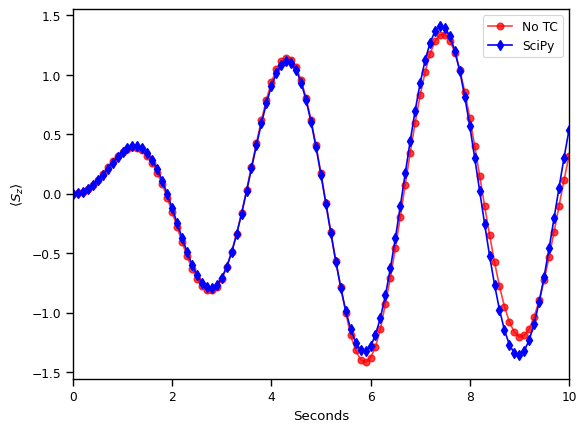

In [13]:
expval = np.array([ele[0][0].real for ele in evolution_result_re.observables])
times = evolution_result_re.times
exact_mz_exp_val_re_test = solution_test.observables[0][0].real

sns.set_context("paper")
fig, ax = plt.subplots(1,1)
DELTA_BIG = 4
ax.plot(times[::DELTA_BIG], expval[::DELTA_BIG], '-ro', label= "No TC", alpha=0.75)
ax.plot(times[::DELTA_BIG], exact_mz_exp_val_re_test[::DELTA_BIG], '-bd', label= "SciPy")
ax.set_xlabel("Seconds")
ax.set_xlim([0, times[-1]])
ax.set_ylabel(r"$\langle S_z \rangle$")
ax.legend()

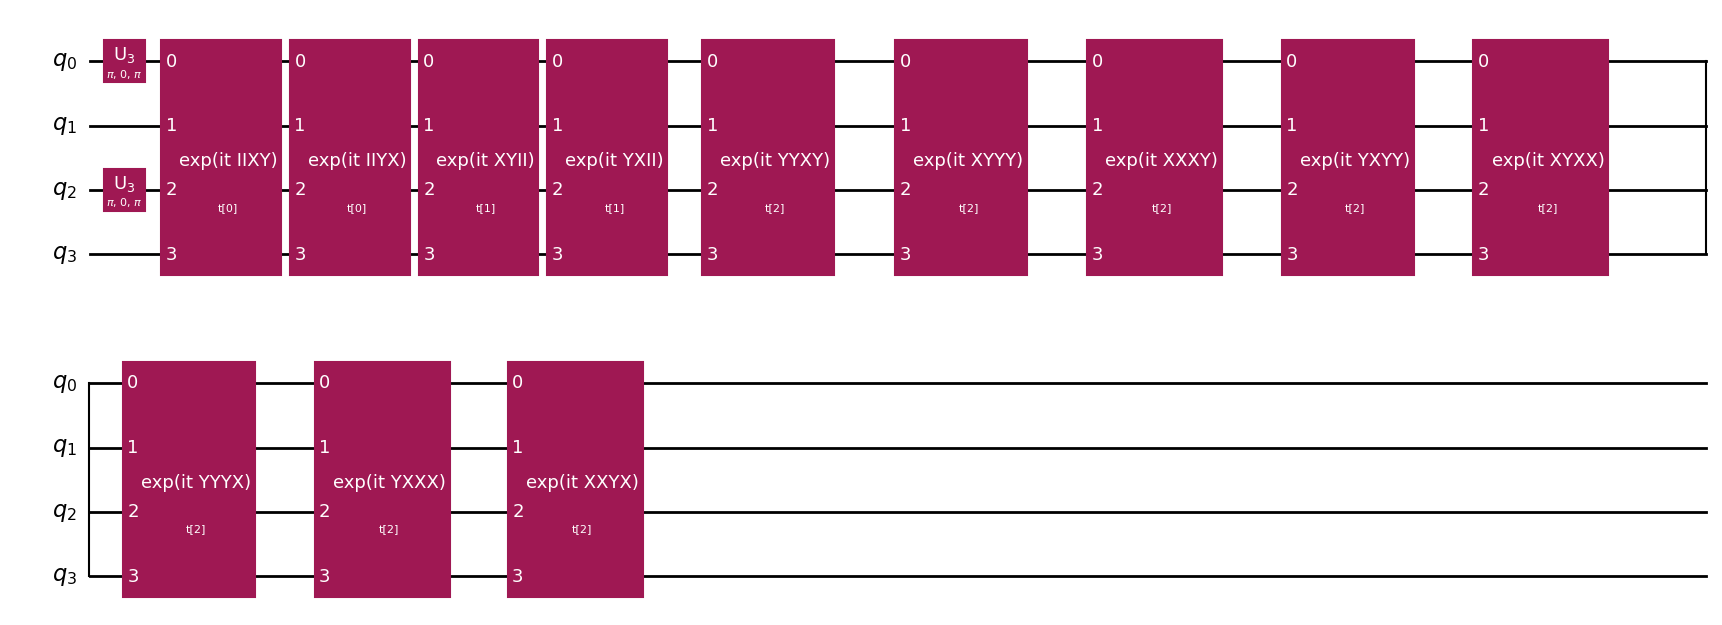

In [164]:
# QRTE
sys = "h2_jw"
#sys = "h4"
#ansatz_type = "HEA"
ansatz_type = "UCCSD"

# TC Hamiltonian
data = np.loadtxt(f'qubit_hamil_{sys}.txt', dtype=str)
paulistrings = data[:,0] 
coefficients = (data[:,1])
coefficients = [complex(coeff) for coeff in coefficients]
paulis = list(zip(paulistrings, coefficients))
hamiltonian_tc = SparsePauliOp.from_list(paulis)
hamiltonian_tc = hamiltonian_tc.adjoint()

# No TC Hamiltonian
if sys == "h4":
    driver = PySCFDriver(
        atom = "H 0 0 0; H 0 0 1.23; H 0 1.23 0; H 0 1.23 1.23",
        unit=DistanceUnit.ANGSTROM,
        charge=0,
        spin=0,
        basis='sto6g'
    )
    qrte_problem = driver.run()
    h = qrte_problem.hamiltonian.second_q_op()
    mapper = ParityMapper(num_particles = qrte_problem.num_particles)
    hamiltonian = mapper.map(h)
elif sys == "h2_jw":
    driver = PySCFDriver(
        atom = "H 0 0 0; H 0 0 0.7",
        unit=DistanceUnit.ANGSTROM,
        charge=0,
        spin=0,
        basis='sto6g'
    )
    qrte_problem = driver.run()
    h = qrte_problem.hamiltonian.second_q_op()
    mapper = JordanWignerMapper()
    hamiltonian = mapper.map(h)

# Magnetisation
data = np.loadtxt(f'qubit_sz_{sys}.txt', dtype=str)
paulistrings = []
coefficients = []
for datum in data:
    datum = datum.split("*")
    paulistrings.append(datum[1])
    coefficients.append(datum[0])
coefficients = [complex(coeff) for coeff in coefficients]
paulis = list(zip(paulistrings, coefficients))
magnetisation = SparsePauliOp.from_list(paulis)
#magnetisation = magnetisation.adjoint()
#print(magnetisation)

# Ansatz

if ansatz_type == "UCCSD":
    initial_circuit = HartreeFock(qrte_problem.num_spatial_orbitals, qrte_problem.num_particles, mapper)
    ansatz_qrte = UCCSD(num_spatial_orbitals = qrte_problem.num_spatial_orbitals, num_particles = qrte_problem.num_particles, qubit_mapper=mapper, initial_state=initial_circuit)
    init_param_values_qrte = [0 for _ in range(ansatz_qrte.num_parameters)]
elif sys == "h2_jw":
    ansatz_qrte = EfficientSU2(num_qubits = hamiltonian.num_qubits, reps=1, skip_final_rotation_layer=True)
    init_param_values_qrte = [np.pi,np.pi,0,0,0,0,0,0] # 0101, HF
    #init_param_values_qrte = [np.pi,0,0,0,0,0,0,0] # 0011, two spin ups, triplet.
    #init_param_values_qrte = [np.pi,np.pi/2,0,0,0,0,0,0] # N(|S>+|T>)
elif sys == "h4":
    ansatz_qrte = EfficientSU2(num_qubits = hamiltonian.num_qubits, reps=1, skip_final_rotation_layer=True)
    init_param_values_qrte = [np.pi,np.pi,np.pi,0,0,0,0,0,0,0,0,0] # HF
    #init_param_values_qrte = [-np.pi/2 for _ in range(ansatz_qrte.num_parameters)] # something everywhere

state = Statevector.from_int(0, 2**hamiltonian.num_qubits)
test_circ = ansatz_qrte.assign_parameters(init_param_values_qrte)
state = state.evolve(test_circ)
state.draw('latex')
#ansatz_qrte.decompose().draw("mpl") # HEA
ansatz_qrte.decompose().decompose().draw("mpl") # UCCSD

In [108]:
# No TC case

# The 2 main tunable parameters
total_time = 50
num_timesteps = 200

var_principle = RealMcLachlanPrinciple(qgt=LinCombQGT(estimator), gradient=LinCombEstimatorGradient(estimator))
time_evo_qrte = TimeEvolutionProblem(hamiltonian, 
                                time=total_time, 
                                aux_operators=[magnetisation])
qrte = VarQRTE(ansatz_qrte, init_param_values_qrte, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
real_result_notc = qrte.evolve(time_evo_qrte)

I want you to know that Hermiticity is False according to my beliefs
[-8.00301618e-18  2.13444249e-19  2.11475679e-32]
[-8.00301618e-18  2.13444249e-19  2.11475679e-32]
[-8.00301618e-18  2.13444249e-19  2.11475679e-32]
[-8.00301618e-18  2.13444249e-19  2.11475679e-32]
[-8.00301618e-18  2.13444249e-19  2.12799400e-32]
[-8.00301618e-18  2.13444249e-19  2.10873470e-32]
[-8.00301618e-18  2.13444249e-19  2.11779861e-32]
[-8.00301618e-18  2.13444249e-19  2.23153557e-32]
[-8.00301618e-18  2.13444249e-19  2.23153557e-32]
[-8.00301618e-18  2.13444249e-19  1.93343205e-32]
[-8.00301618e-18  2.13444249e-19  2.25079487e-32]
[-8.00301618e-18  2.13444249e-19  2.25079487e-32]
[-8.00301618e-18  2.13444249e-19  2.25079487e-32]
[-8.00301618e-18  2.13444249e-19  1.91767159e-32]
[-8.00301618e-18  2.13444249e-19  1.91767159e-32]
[-8.00301618e-18  2.13444249e-19  1.87542673e-32]
[-8.00301618e-18  2.13444249e-19  1.87542673e-32]
[-8.00301618e-18  2.13444249e-19  1.93364133e-32]
[-8.00301618e-18  2.13444249e-1

In [160]:
# Compare with exact solutions
init_circ1 = ansatz_qrte.assign_parameters(init_param_values_qrte)
evolution_problem = TimeEvolutionProblem(
    hamiltonian, total_time, initial_state=init_circ1, aux_operators=[hamiltonian]
)
rtev1 = SciPyRealEvolver(num_timesteps)
sol1 = rtev1.evolve(evolution_problem)

init_circ2 = ansatz_qrte.assign_parameters(init_param_values_qrte)
evolution_problem2 = TimeEvolutionProblem(
    hamiltonian_tc, total_time, initial_state=init_circ2, aux_operators=[magnetisation]
)
rtev2 = SciPyRealEvolver(num_timesteps)
sol2 = rtev2.evolve(evolution_problem2)

First value = 0.0


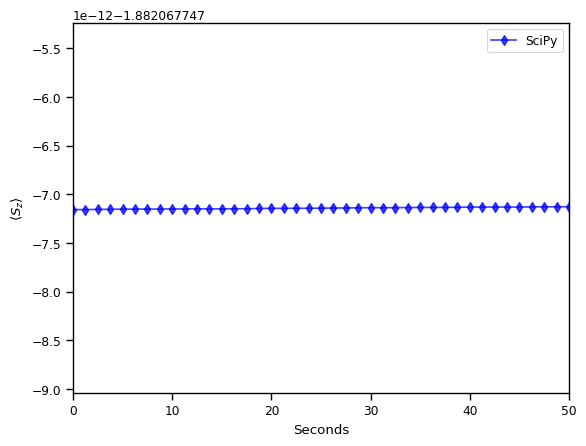

In [163]:
sns.set_context("paper")
fig, ax = plt.subplots(1,1)
#fig.set_figheight(7)
#fig.set_figwidth(5)

DELTA_BIG = 5

exp_val_real_notc = np.array([ele[0][0].real for ele in real_result_notc.observables])
times = real_result_notc.times
#exp_val_real = np.array([ele[0][0].real for ele in real_result.observables])
#times = real_result.times
exact_mz_exp_val_re = sol1.observables[0][0].real
exact_mz_exp_val_re_tc = sol2.observables[0][0].real

print("First value =", exp_val_real_notc[0]) # E: -1.2427 for triplet, -1.8820 for singlet

#ax.plot(times[::DELTA_BIG], exp_val_real_notc[::DELTA_BIG], '-ro', label= "No TC", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
#ax.plot(times[::DELTA_BIG], exp_val_real[::DELTA_BIG], '-gs', label= "TC", alpha=0.76) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times[::DELTA_BIG], exact_mz_exp_val_re[::DELTA_BIG], '-bd', label= "SciPy", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
#ax.plot(times[::DELTA_BIG], exact_mz_exp_val_re_tc[::DELTA_BIG], '-c^', label= "SciPy TC")

ax.set_xlabel("Seconds")
ax.set_xlim([0, times[-1]])
ax.set_ylabel(r"$\langle S_z \rangle$")
ax.legend()
#ax.set_ylim([-.5,.5])

(16,)


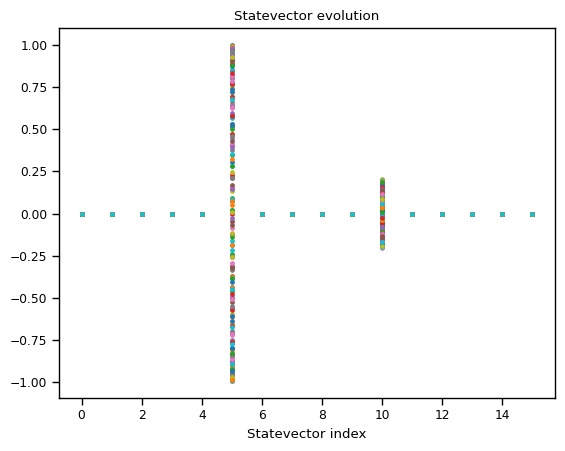

[-5.01965807e-35-2.97444964e-33j  9.18930525e-18+8.67296376e-17j
 -3.08148791e-33+9.65386579e-52j -1.41866883e-33+9.44671661e-35j
 -2.33283743e-17+2.64586291e-18j  1.00000000e+00+5.38993555e-34j
 -4.34303367e-33+2.60103754e-36j  3.74199667e-17+9.57231111e-19j
  9.55883584e-53+1.50619778e-33j  8.88909827e-35-1.62588398e-17j
 -1.08947050e-33+1.49211207e-68j -2.31286613e-33-2.90635853e-51j
  7.27088025e-34+2.44652021e-34j  2.39507028e-17+2.11611269e-17j
  1.45442524e-50-2.74234490e-51j -3.81024741e-33-1.44574410e-34j]


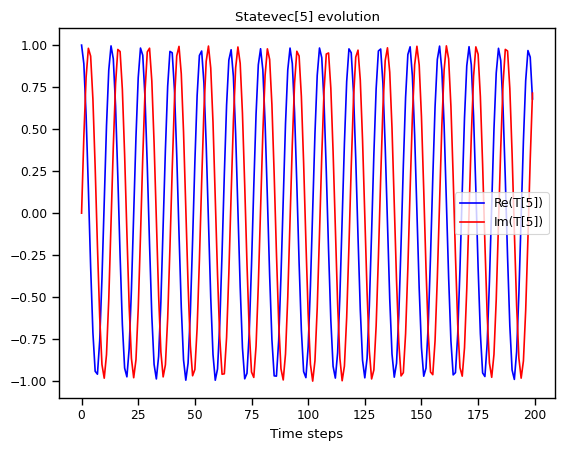

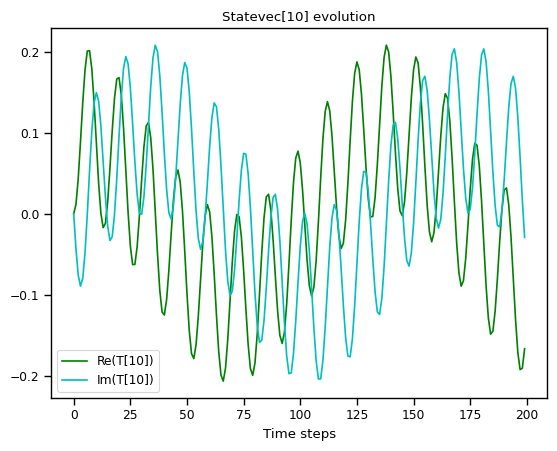

In [159]:
hmat = hamiltonian.to_matrix()
state = Statevector.from_int(0, 2**hamiltonian.num_qubits)
test_circ = ansatz_qrte.assign_parameters(init_param_values_qrte)
state = state.evolve(test_circ)
statevec_0 = state.data

print(statevec_0.shape)

def time_evo(t):
    return la.expm(-1j*hmat*t)@statevec_0

times = np.linspace(0, total_time, num_timesteps)
statevec_t = np.array([time_evo(t) for t in times])

for statevec in statevec_t:
    plt.plot(np.real(statevec), linestyle = "none", marker = ".", label = "t") # 5, 10 seems to be the important ones
    #plt.plot(np.imag(statevec), linestyle = "none", marker = ".", label = "t")
plt.xlabel("Statevector index")
plt.title("Statevector evolution")
plt.show()

plt.figure()
plt.plot(np.real(statevec_t[:,5]), "b-", label="Re(T[5])")
plt.plot(np.imag(statevec_t[:,5]), "r-", label="Im(T[5])")
plt.xlabel("Time steps")
plt.title("Statevec[5] evolution")
plt.legend()

plt.figure()
plt.plot(np.real(statevec_t[:,10]), "g-", label="Re(T[10])")
plt.plot(np.imag(statevec_t[:,10]), "c-", label="Im(T[10])")
plt.xlabel("Time steps")
plt.title("Statevec[10] evolution")
plt.legend()

print(statevec_0)




In [154]:
state.draw('latex')

<IPython.core.display.Latex object>

(4,)


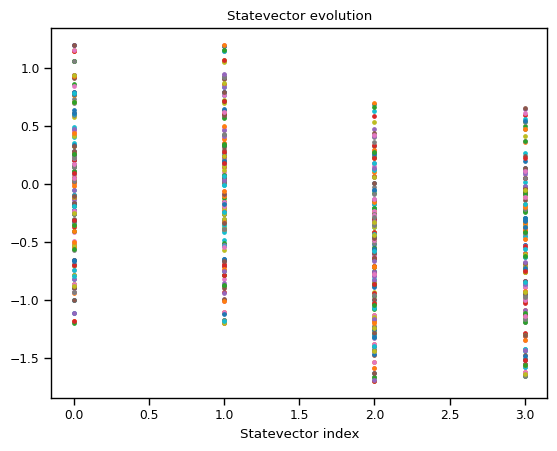

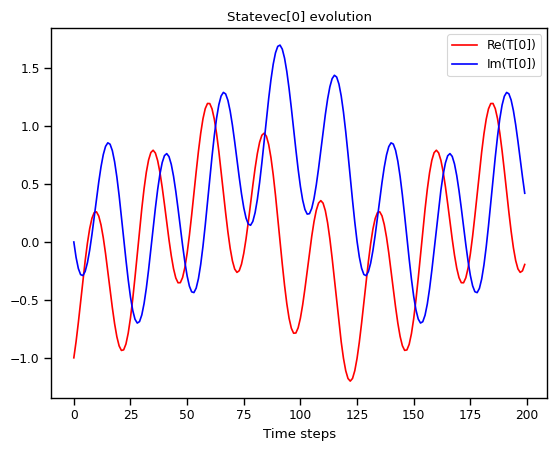

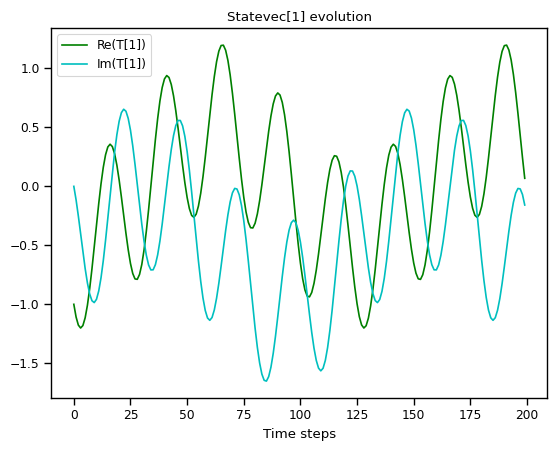

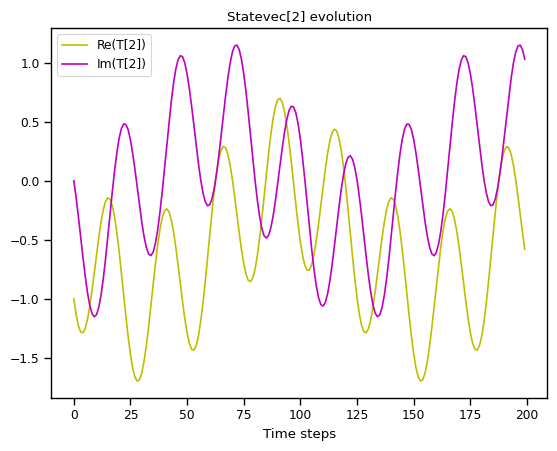

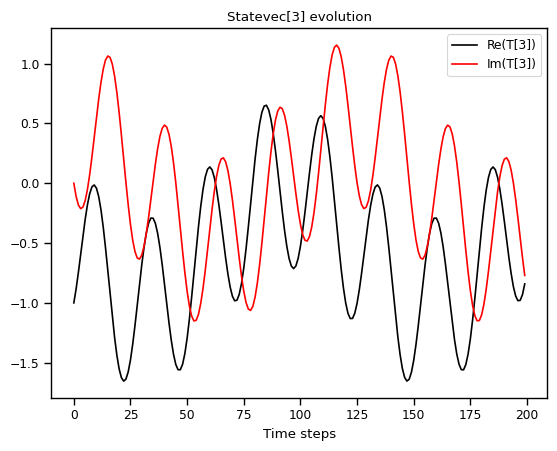

In [158]:
# Compare with test system
hmat = hamiltonian_test.to_matrix()
state = Statevector.from_int(0, 2**hamiltonian_test.num_qubits)
test_circ = ansatz_test.assign_parameters(init_param_values_test)
state = state.evolve(test_circ)
statevec_0 = state.data

print(statevec_0.shape)

def time_evo(t):
    return np.exp(-1j*hmat*t)@statevec_0

times = np.linspace(0, total_time, num_timesteps)
statevec_t = np.array([time_evo(t) for t in times])

for statevec in statevec_t:
    plt.plot(np.real(statevec), linestyle = "none", marker = ".", label = "t") # 5, 10 seems to be the important ones
plt.xlabel("Statevector index")
plt.title("Statevector evolution")
plt.show()

plt.figure()
plt.plot(np.real(statevec_t[:,0]), "r-", label="Re(T[0])")
plt.plot(np.imag(statevec_t[:,0]), "b-", label="Im(T[0])")
plt.xlabel("Time steps")
plt.title("Statevec[0] evolution")
plt.legend()

plt.figure()
plt.plot(np.real(statevec_t[:,1]), "g-", label="Re(T[1])")
plt.plot(np.imag(statevec_t[:,1]), "c-", label="Im(T[1])")
plt.xlabel("Time steps")
plt.title("Statevec[1] evolution")
plt.legend()

plt.figure()
plt.plot(np.real(statevec_t[:,2]), "y-", label="Re(T[2])")
plt.plot(np.imag(statevec_t[:,2]), "m-", label="Im(T[2])")
plt.xlabel("Time steps")
plt.title("Statevec[2] evolution")
plt.legend()

plt.figure()
plt.plot(np.real(statevec_t[:,3]), "k-", label="Re(T[3])")
plt.plot(np.imag(statevec_t[:,3]), "r-", label="Im(T[3])")
plt.xlabel("Time steps")
plt.title("Statevec[3] evolution")
plt.legend()
